# Obama vs Trump Image Classification

In this notebook, I download images of president Obama & Trump, and build a classifier to predict who is who. The code is based on fast.ai lectures.

I used the google image download utility from https://github.com/hardikvasa/google-images-download.git and wrapped into another function is a separate python file (download_img_list.py).

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import random

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

assert torch.cuda.is_available() & torch.backends.cudnn.enabled

PATH = "data/obama_trump_class/"
PATH_TRAIN = PATH+'train/'
DOWNLOAD_FLAG = False  # Select false if we have already donwloaded the images + labels

if not os.path.exists(PATH_TRAIN):
    os.makedirs(PATH_TRAIN)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Download Images

In [2]:
# Uncomment if running for the first time
#!git clone https://github.com/hardikvasa/google-images-download.git
#shutil.move("google-images-download/google_images_download", "img_downloader")
#shutil.rmtree("google-images-download")

In [3]:
if DOWNLOAD_FLAG:
    
    import download_img_list
    
    presidents = ['Barack Obama', 'Donald Trump']
    
    labels, err_list = download_img_list.download_img_list(presidents, PATH_TRAIN, 100)
    labels.to_csv(PATH+'labels.csv', index = False)
    
    print('\nPresidents that did not download: ')
    print(err_list)
else:
    labels = pd.read_csv(PATH+'labels.csv')

In [4]:
labels.groupby('label').size().sort_values()

label
Barack_Obama    93
Donald_Trump    97
dtype: int64

## Look at the downloaded Images

In [5]:
def showPresident(name, labels = labels, dims = (1, 3), directory = PATH_TRAIN):
    '''Show images of a given president'''
    nrows, ncols = dims
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize =(ncols * 5, nrows * 5))
    fns = list(labels['id'][labels['label'] == name])
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            if nrows > 1:
                axes[i, j].imshow(plt.imread(directory+fns[k]), cmap = 'gray')
            else:
                axes[j].imshow(plt.imread(directory+fns[k]), cmap = 'gray')
            k = (k + 1) % (len(fns))

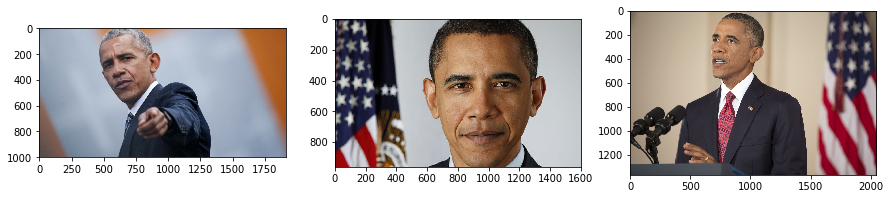

In [6]:
showPresident("Barack_Obama")

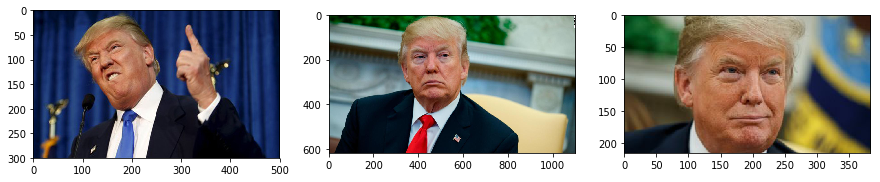

In [7]:
showPresident("Donald_Trump")

## Fit Model

Since I only have ~200 training examples, I don't run lr_find (as even with bs = 32, there are only ~7 minibatches).

In [8]:
sz = 224
bs = 32
arch = resnet34
val_idxs = get_cv_idxs(len(labels.index), seed = 42)
data = ImageClassifierData.from_csv(PATH, 'train/', PATH+'labels.csv', bs = bs, 
                                    tfms = tfms_from_model(arch, sz), val_idxs = val_idxs)
learn = ConvLearner.pretrained(arch, data, precompute = True)

In [9]:
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy               
    0      0.880586   0.646552   0.631579  
    1      0.66308    0.451502   0.842105        
    2      0.529175   0.390033   0.894737        



[array([0.39003]), 0.8947368421052632]

The training loss is higher than the validation loss, so let's keep on training.

In [10]:
learn.fit(0.01, 1, cycle_len=3)

epoch      trn_loss   val_loss   accuracy        
    0      0.200939   0.385418   0.868421  
    1      0.196131   0.382742   0.868421        
    2      0.191711   0.380883   0.868421        



[array([0.38088]), 0.8684210494944924]

In [11]:
learn.save('Obama_Trumpv1')

## Looking at the Results

In [12]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds)
y = data.val_y

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

cm

array([[16,  2],
       [ 3, 17]])

## Add data augmentations, set size to 299

In [14]:
learn.load('Obama_Trumpv1')

In [15]:
sz = 299

In [16]:
tfms = tfms_from_model(arch, sz, transforms_side_on, max_zoom=1.15)

In [17]:
data = ImageClassifierData.from_csv(PATH, 'train/', PATH + 'labels.csv', bs, tfms, val_idxs=val_idxs)

In [18]:
learn.set_data(data, precompute = False)

In [19]:
learn.fit(0.01 /2, 2)

epoch      trn_loss   val_loss   accuracy        
    0      0.180377   0.3788     0.868421  
    1      0.184616   0.37307    0.868421        



[array([0.37307]), 0.8684210494944924]

In [20]:
learn.save('Obama_Trumpv2')

## Unfreeze layers

In [21]:
#learn.load('Obama_Trumpv2')

In [22]:
lr = 0.01 / 10
lrs = [lr/100, lr/10, lr]

In [23]:
learn.unfreeze()

In [24]:
learn.fit(lrs, 1, cycle_len=3)

epoch      trn_loss   val_loss   accuracy                
    0      0.422256   0.471264   0.789474  
    1      0.379338   0.466964   0.868421                
    2      0.357998   0.461071   0.868421                



[array([0.46107]), 0.868421052631579]

In [25]:
learn.save('Obama_Trumpv3')

## Look at the Results

In [26]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_correct(cat, is_correct = True, num = 4): 
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == cat)
    idxs = np.where(mask, )[0]
    mult = -1 if is_correct else 1
    return idxs[np.argsort(mult*probs[:, cat][idxs])[:num]]

def plot_val_with_title(cat, is_correct = True, title = '', num = 4):
    idxs = most_by_correct(cat, is_correct, num)
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[:, cat][x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [27]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis = 1)
probs = np.exp(log_preds)
y = data.val_y

cm = confusion_matrix(y, preds)

cm

array([[16,  2],
       [ 3, 17]])

In [28]:
log_preds, y = learn.TTA()

In [29]:
probs = np.mean(np.exp(log_preds),0)

In [30]:
preds = np.argmax(probs, axis = 1)

cm = confusion_matrix(y, preds)

cm

array([[15,  3],
       [ 4, 16]])

Looks like TTA made the result worse. Probably just because the data size is small, volatile, and at this point we have probably over-fitted the validation set.

Most Incorrect Obama Pics


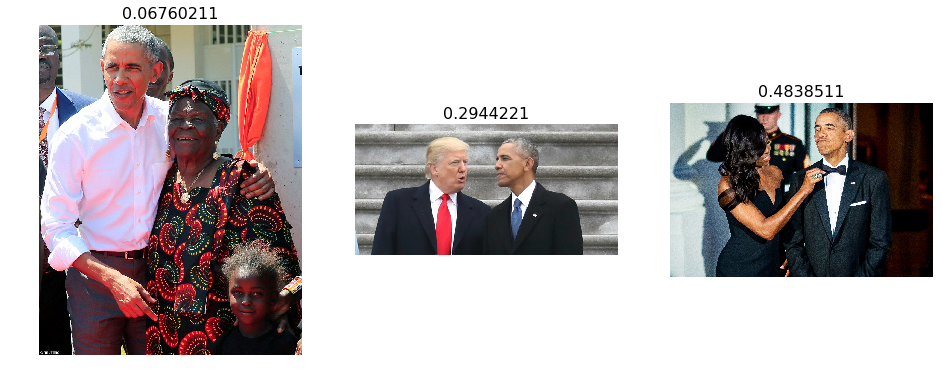

In [31]:
plot_val_with_title(0, False, 'Most Incorrect Obama Pics')

Most Incorrect Trump Pics


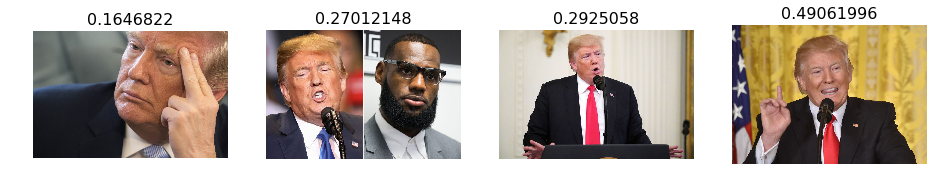

In [32]:
plot_val_with_title(1, False, 'Most Incorrect Trump Pics')

If we don't count the misclassified images with two people in them, we have 3 misclassifications out of 38 validation set images.